In [169]:
import numpy as np
import tensorflow as tf
import keras_nlp
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Embedding, Add
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [180]:
# data loading

with gzip.open('../data/segment_with_noise/ll_seg_gps_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_gps_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gps_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gps_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,y_norm,x_norm,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.795350,0.203490
43617,42.246167,-83.563112,0.785304,0.204631,0.787305,0.203073
43667,42.246155,-83.563137,0.784089,0.202890,0.788982,0.203170
43717,42.246143,-83.563163,0.782877,0.201164,0.794082,0.195338
43767,42.246131,-83.563188,0.781676,0.199454,0.791014,0.203958


In [192]:
ll_seg_gps_noise[0][['y_norm_noise', 'x_norm_noise']].values[0]

array([0.79535004, 0.20348973])

In [216]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_gt_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    x_ll.append(df[['y_norm_noise', 'x_norm_noise']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)
    # y_ll.append(list(df[['y_norm', 'x_norm']].itertuples(index=False, name=None)))

for df in ll_seg_gps_gt:
    y_gt_ll.append(df[['y_norm', 'x_norm']].values)
    # y_ll.append(list(df[['y_norm', 'x_norm']].itertuples(index=False, name=None)))

In [182]:
# 500 segment samples with length 77
len(x_ll), len(x_ll[0])

(500, 77)

In [186]:
len(x_ll[0]), len(x_ll[2])

(77, 77)

In [184]:
# 500 segment samples with length 3822
len(y_ll), len(y_ll[0])

(500, 3822)

In [20]:
np.array([0.1, 0.2, 0.3]).reshape((1,3,1))

array([[[0.1],
        [0.2],
        [0.3]]])

## model 1: LSTM based seq2seq model

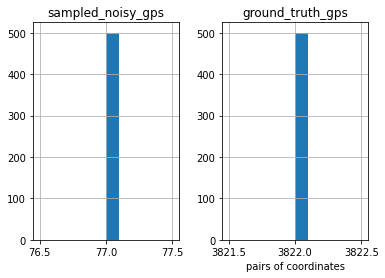

In [217]:
x_count = []
y_count = []

for x_seg in x_ll:
    x_count.append(len(x_seg))
for y_seg in y_gt_ll:
    y_count.append(len(y_seg))

graph_df = pd.DataFrame() 

graph_df['sampled_noisy_gps'] = x_count
graph_df['ground_truth_gps'] = y_count

graph_df.hist(bins = 10)
plt.xlabel('pairs of coordinates')
plt.show()

In [188]:
# selecting max_y_len and max_x_len
max_y_len = max([len(y_seg) for y_seg in y_gt_ll])
max_x_len = max([len(x_seg) for x_seg in x_ll])

max_y_len, max_x_len

(3822, 77)

In [218]:
x_train, x_val, y_train, y_val = train_test_split(
    np.asarray(x_ll),
    np.asarray(y_gps_ll),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [209]:
x_train_temp = np.asarray([np.arange(max_x_len) for i in np.arange(x_train.shape[0])])
print(x_train_temp.shape)
x_train_temp

(450, 77)


array([[ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       ...,
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76]])

In [213]:
x_train.shape, x_train_temp.shape

((450, 77, 2), (450, 77))

In [231]:
input1 = Input(shape=(77,2,))
h_spat = Dense(64)(input1)

input2 = Input(shape=(77,))
h_temp = Embedding(max_x_len+1, 64, input_length=max_x_len+1)(input2)

h_st = Add()([h_spat, h_temp])
model = Model(inputs=[input1, input2], outputs=h_st)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [233]:
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 77, 2)]      0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 77)]         0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 77, 64)       192         ['input_29[0][0]']               
                                                                                                  
 embedding_24 (Embedding)       (None, 77, 64)       4992        ['input_30[0][0]']               
                                                                                            

In [229]:
a = np.random.randint(100, size=(450, 77, 64))

In [232]:
model.fit(
    [x_train, x_train_temp], a, epochs=1, verbose=0
)

In [212]:
# batch, seq_length, embedd_length
(Dense(64, )(x_train) + Embedding(max_x_len+1, 64, input_length=max_x_len+1)(x_train_temp)).shape

TensorShape([450, 77, 64])